这是你的第一个DataFrame:
            open  high  low  close  volume  price_change
open_time                                               
2023-01-01   100   103   99    102    1000             2
2023-01-02   102   106  101    105    1500             3
2023-01-03   105   106  102    103    1200            -2
2023-01-04   103   107  101    107    1800             4
2023-01-05   108   110  107    109    2000             1

每日的价格变化:
open_time
2023-01-01    2
2023-01-02    3
2023-01-03   -2
2023-01-04    4
2023-01-05    1
Name: price_change, dtype: int64


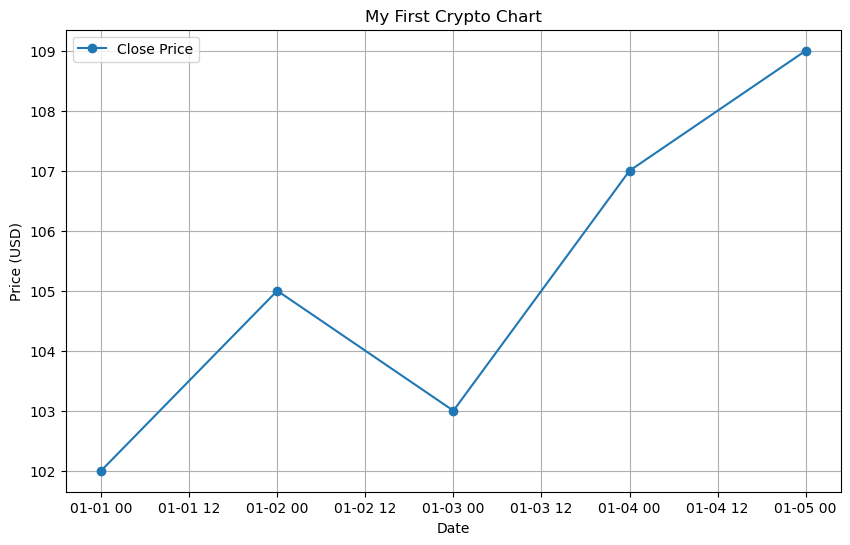

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 创建模拟的K线数据
# 想象这就像你在JS中创建一个对象数组
data = {
    'open_time': pd.to_datetime(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05']),
    'open': [100, 102, 105, 103, 108],
    'high': [103, 106, 106, 107, 110],
    'low': [99, 101, 102, 101, 107],
    'close': [102, 105, 103, 107, 109],
    'volume': [1000, 1500, 1200, 1800, 2000]
}

# 2. 将数据转换为Pandas DataFrame
# 这就是你的核心数据结构
df = pd.DataFrame(data)
df.set_index('open_time', inplace=True) # 将时间设置为索引，这在时间序列分析中是标准操作

# 3. 进行简单的“向量化”计算
# 计算每日的收盘价与开盘价的价差，注意这里没有用for循环
df['price_change'] = df['close'] - df['open']

# 4. 输出查看
print("这是你的第一个DataFrame:")
print(df)
print("\n每日的价格变化:")
print(df['price_change'])

# 5. 使用Matplotlib进行可视化
# 就像你在前端使用echarts或d3.js
plt.figure(figsize=(10, 6)) # 创建一个10x6英寸的画布
plt.plot(df.index, df['close'], label='Close Price', marker='o') # 绘制收盘价曲线
plt.title('My First Crypto Chart') # 图表标题
plt.xlabel('Date') # X轴标签
plt.ylabel('Price (USD)') # Y轴标签
plt.legend() # 显示图例
plt.grid(True) # 显示网格
plt.show() # 显示图表

### df['close'] - df['open'] 这种整列相减的操作，和JavaScript数组操作相比，其底层逻辑可能有什么不同？为什么它会更高效？

>这个问题本质上是在比较 Pandas（底层 Cython/NumPy 实现） 和 JavaScript 原生数组操作 在处理整列数据时的机制差异。虽然两者看起来语法都很简洁，但底层效率差别很大，原因在于数据存储方式和运算执行方式。

| 对比维度 | Pandas / NumPy (`df['close'] - df['open']`) | JavaScript 数组 (`arr1.map((v, i) => v - arr2[i])`) |
| :--- | :--- | :--- |
| **数据存储** | - 底层是连续的内存块 (homogeneous dtype, 如 float64 数组) <br>- 使用 NumPy 的 ndarray，C 语言分配内存 | - 每个元素是一个对象引用 (可能是 number, 但 JS number 是双精度浮点包装) <br>- 元素在堆上分散存储 |
| **类型一致性** | - 强类型 (所有元素同一类型) <br>- 无需逐元素做类型检查 | - 动态类型, 运算前可能需要做类型推断和隐式转换 |
| **循环执行** | - 由 C 级别的循环一次性向量化处理 (SIMD 优化) <br>- Python 只发出一个运算指令, 循环在底层库中完成 | - JS 的 `.map()` / `for` 循环是解释执行, 每个元素运行一次 JS 函数调用 |
| **CPU 缓存友好度** | - 数据连续排列, CPU 预取和缓存命中率高 | - 元素分散, 缓存命中率低 |
| **额外开销** | - 几乎无函数调用开销<br>- 一次性批量计算 | - 每次循环一次就有函数栈开销和闭包捕获变量的额外负担 |

------------------------------------------------------------

🚀 为什么 Pandas 会快很多
1. 向量化计算 `df['close'] - df['open']` 会调用底层 C 函数执行整个数组的减法，运算发生在编译好的机器码里，一次性处理大量数据，而不是 Python 循环。

2. 无解释器干扰 Python 层只发出一个“减法”操作，剩下的都在 NumPy 的 C 层运行，不需要每个元素都回到 Python 或 JS 解释器执行。

3. 类型稳定 NumPy 数组是定长、同类型的连续内存，CPU 可以一次读取多个数据到寄存器（SIMD），而 JS 动态类型会导致 JIT 编译器生成更复杂的检查逻辑。

4. 内存布局优化 连续的二进制数据更容易利用 CPU Cache，而 JS 数组在底层更像“指针数组”，需要多次内存寻址才能访问到实际数值。

------------------------------------------------------------
🔍 简单性能对比示例（思路）
假设有 1,000,000 个元素做减法：
- Pandas / NumPy
  ```python
  import numpy as np
  a = np.random.rand(1_000_000)
  b = np.random.rand(1_000_000)
  c = a - b  # C 层批量完成
  ```
- JavaScript
  ```javascript
  const arr1 = new Array(1000000).fill(0).map(() => Math.random());
  const arr2 = new Array(1000000).fill(0).map(() => Math.random());
  const arr3 = arr1.map((v, i) => v - arr2[i]);  // JS 层循环执行 每个元素调用一次回调
  ```
在同等硬件上，NumPy 版本可能快几十倍到上百倍，因为它减少了函数调用开销，并且用的是底层优化好的内存操作。

--------------------------------------------------------------
💡 总结 `df['close'] - df['open']` 高效的原因：

- 向量化 + C 实现（减少解释器开销）

- 连续内存 + CPU 缓存友好

- 固定数据类型 + SIMD 优化


##### 为什么对于时间序列数据，将时间设置为索引（Index）会是一个好主意？它可能为我们后续的数据操作带来哪些便利？

>把时间列设为 Index，相当于给 DataFrame 装上了一台“时间坐标系”的引擎，这对时间序列分析来说好处非常多，不只是语法简洁，还能解锁一系列底层优化功能。


| 维度 | 作用 | 为什么重要 |
| :--- | :--- | :--- |
| **快速定位** | 可以直接使用时间切片: <br> `df['2024-01']` / `df['2024-01-15':'2024-01-20']` | 内部会用二分查找快速定位时间区间, 比常规条件过滤更高效 |
| **对齐与重采样** | 支持 `.resample('D')` 、 `.asfreq('H')` 等时间频率变换 | 方便做日线→周线、分钟→小时等聚合分析 |
| **自动排序** | 时间索引通常按时间顺序存储, 方便后续运算 | 对绘图、移动窗口计算等尤为关键 |
| **滚动窗口** | `.rolling('7D')` 可以用天数而非行数滑动计算 | 更贴近实际业务需求 (如移动均线、滑动相关系数) |
| **合并与对齐** | 以时间为键合并不同频率的数据集时更自然 | 避免手动 join 时的麻烦对齐逻辑 |
| **可读性** | 从代码层面直观表达“这是一个随时间变化的数据集” | 在多人协作或复盘代码时更清晰 |

⚙️ 为什么会更高效
- 索引是哈希或排序数组：当时间设为 Index 后，底层可用 有序索引 + 二分法 快速查找，时间切片接近 O(log n)。

- 减少数据复制：`set_index`（尤其 `inplace=True`）不会频繁复制整列，节省内存。

- 底层时间戳类型优化：Pandas 使用 `datetime64[ns]` 存储时间，可在 C 层用整数比较，非常快。

💡 举个简单对比
```python
# 时间作为普通列
df[(df['open_time'] >= '2024-01-15') & (df['open_time'] < '2024-01-20')]

# 时间作为索引
df['2024-01-15':'2024-01-20']   # 语法更短、速度更快
```
在大数据量（百万级行数）下，后者的执行效率和可读性优势会非常明显。

##### 如果这份数据不是手动创建的，而是一个包含百万行数据的CSV文件，你觉得在加载（pd.read_csv()）和处理时，可能会遇到哪些在前端开发中不常见的挑战？（提示：从内存和性能角度思考）

>在前端，数据集通常更分片、流式化，或者经过后端 API 预处理，几乎不会一次性在浏览器内存中“硬吃”百万行原始数据；但在 Pandas 的世界里，pd.read_csv() 默认会一次性把整个文件加载到内存，这就带来了内存和性能上的挑战。

| 维度 | Python Pandas 加载百万行 CSV | 前端常见模式 | 典型问题 |
| :--- | :--- | :--- | :--- |
| **内存占用** | 一次性加载到内存, DataFrame 会额外有索引、dtype 等开销, 内存用量常是文件体积的 3~10 倍 | 流式读取 (WebSocket / fetch 分片)、虚拟列表 | 可能直接 OOM (内存溢出) |
| **数据类型推断** | `read_csv` 默认自动推断 dtype, 需要扫描数据样本甚至整列 | JSON/JS 原生类型相对固定 (string/number/boolean) | 推断耗时、dtype 不最优导致更多内存占用 |
| **磁盘 I/O** | 需要一次性顺序读取整个文件 | 前端直接接收 API 响应, I/O 由服务器处理 | 大文件读取时间长, SSD/HDD 差异大 |
| **计算延迟** | 向量化运算快, 但数据量大时任何操作 (过滤/分组/merge) 都可能几秒甚至数十秒 | 前端只处理少量分页数据 | 用户交互延迟高 |
| **并发限制** | 单进程 GIL 下 CPU 绑定任务无法多线程并行 (需用多进程或 Dask/Spark) | 浏览器多线程用 Web Workers 或 GPU 加速 | Python 原生多线程对 CPU 密集型任务不理想 |
| **存储格式** | CSV 纯文本, 占用大, 解析慢 | API 可返回压缩二进制 (protobuf、parquet) | 读取和解析同时消耗 CPU |

🛠️ 优化方向（Python 角度）
用 前端类比 来解释，可能更容易切换思路：
1. 流式/分块读取
  - 类似前端的 infinite scroll，用 pd.read_csv(..., chunksize=100000) 分块读取，分批处理
  - 每块是一个小 DataFrame，可边读边处理边丢弃，降低内存峰值
2. 提前声明 dtype
  - 就像 API 返回时你已定义数据 schema，可以用 dtype={'col': 'int32', ...} 避免自动推断
3. 用高效存储格式
  - 把 CSV 转成 Parquet/Feather，相当于把 JSON 转成二进制
  - 读取速度可提速 5~10 倍，内存也更紧凑
4. 选择性读取列
  - 用 `usecols=['close', 'volume']` 类似 API 只返回需要的字段，减少宽度
5. 内存优化
  - 用 `.astype('category')` 压缩枚举型字符串列
  - 用 `float32`/`int32` 代替默认的 `float64`/`int64`
6. 并行处理
  - 对超大数据集考虑用 Dask（类比前端用 Web Workers 并行任务分发）或 PySpark

不光可以优化读取方式，从文件格式本身入手其实是更“底层”的性能策略，而且对存储大规模金融数据尤其重要。 CSV 只是“能用”，但并不是“最优”——它有几个天生的短板，特别是在这种高频、长历史的行情/交易数据场景里会放大。

🛠 CSV 格式的天然缺陷

| 层面 | CSV 的特点 | 金融大数据场景中的问题 |
| :--- | :--- | :--- |
| **存储效率** | 纯文本, 每个数字都以字符串形式存储 (105.32 → 6 个字节字符+分隔符) | 磁盘占用大, 百万行+几十列的文件动辄几百 MB 甚至 GB |
| **解析速度** | 需要逐字符解析、拆分列、类型推断 | CPU 开销大, `pd.read_csv()` 会慢很多 |
| **类型信息缺失** | 不存储 dtype, 读入时需重新推断 | 每次加载都要扫数据样本 → 增加 I/O 和 CPU 时间 |
| **随机访问问差** | 无索引结构, 想取某个日期区间必须全文顺序读 | 对历史切片、回测等高频区间查询不友好 |
| **压缩利用率低** | 虽然可以用 `.zip` 压缩, 但解压仍需占用临时空间 | 无法像二进制格式那样按列压缩并直接读取 |
| **扩展性差** | 不支持存储元数据 (例如列的单位、说明) | 后续维护、多人协作时需额外管理元数据 |

📈 为什么二进制列式格式更适合金融大数据

| 格式 | 优势 | 适用场景 |
| :--- | :--- | :--- |
| **Parquet** | 列式存储、按列压缩、可存 dtype 和索引、支持分块读取 | 高频行情、多字段回测、分布式计算 (Spark/Dask) |
| **Feather** | 列式存储, 读写超快, 适合临时存储中间结果 | 本地分析、与 Arrow 生态对接 |
| **HDF5** | 支持分块读写, 适合单机大数据集 | 时间序列归档、批量回测 |
| **SQLite/Arrow Table** | 结构化+可索引 | 高频查询、小型交易系统原型 |

💡 列式存储的大杀器在于：

- 按列压缩（比如只压缩 close 这一列），大幅减小磁盘占用

- 按需读取（只读需要的几列，避免加载无关数据）

- 天然支持 dtype（避免反复推断类型）

- 与分布式框架无缝衔接（Spark、Dask 可直接读取 Parquet 分片）

📌 总结建议

- 归档或长期存储：Parquet（压缩好体积小、加载快、可跨语言）

- 临时分析结果：Feather（读写飞快）

- 历史分析+部分实时查询：HDF5（带索引，可分块读）

- CSV 适合 临时跨平台交换数据，但不适合作为大规模金融数据的长期主格式。